# Sales Forecasting Data Science Individual Project

## Import Libraries

In [2]:
# Import all the necessary libraries for the analysis
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from sklearn.preprocessing import StandardScaler
from math import sqrt
import plotly.express as px
import plotly.graph_objects as go
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

## Load the datasets

In [3]:
# Load the datasets using read_csv 
df_sales = pd.read_csv("sales data-set.csv", parse_dates=['Date'])
df_features = pd.read_csv("Features data set.csv", parse_dates=['Date'])
df_stores = pd.read_csv("stores data-set.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'sales data-set.csv'

In [ ]:
# Check the first five rows of the dataset
df_sales.head()

In [ ]:
# Check the shape of the dataset
df_sales.shape

In [ ]:
# Check the first five rows of the dataset
df_features.head()

In [ ]:
# Check the shape of the dataset
df_sales.shape

In [ ]:
# Check the first five rows of the dataset
df_stores.head()

In [ ]:
# Check the shape of the dataset
df_stores.shape

## Data Cleaning

### Check and Handle missing values

In [ ]:
#Check if there is any null values in any of the columns
df_sales.isna().sum()

In [ ]:
#Check if there is any null values in any of the columns
df_stores.isna().sum()

In [ ]:
#Check if there is any null values in any of the columns
df_features.isna().sum()

In [ ]:
#replace all the missing values with 0
df_features=df_features.fillna(0)

In [ ]:
df_features.isna().sum()

### Check data Types and formats

In [ ]:
#Check data Types and formats
print(df_sales.dtypes)
print(df_stores.dtypes)
print(df_features.dtypes)

In [ ]:
#Convert the "Type" column in the stores dataset to category format
df_stores['Type'] =df_stores['Type'].astype('category')
print(df_stores["Type"].dtype)

### Detect Outliers and Treat if there are any

In [ ]:
# Create a function that would detect and remove outliers based on the IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return cleaned_df
# Might affect data so will not be used until later on to see if it will help the improve models or not

### Create the datasets for the models

#### Aggregate Analysis

In [ ]:
# Aggregate the sales data so dates from different stores and departments do not 
# overlap and cause error in the models
# Group by 'Date' and sum 'Weekly_Sales'
aggregate_sales = df_sales.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Sort the 'aggregate_sales' dataframe
aggregate_sales.sort_values('Date', inplace=True)

# Show the first 5 rows of the 'aggregate_sales'
aggregate_sales.head()

In [ ]:
# Prophet requires 'Date' to be denoted as 'ds' and 'Weekly_Sales' to be denoted as 'y'
# so for the prophet model an 'aggregate_sales_prophet' will be created
aggregate_sales_prophet = aggregate_sales[['Date', 'Weekly_Sales']]
aggregate_sales_prophet.columns = ['ds', 'y']
# Show the first 5 rows of the 'aggregate_sales_prophet'
aggregate_sales_prophet.head()

#### Top Performing store/dept combination

In [ ]:
# Find the Top performing department in a top performing store to find out which would be better for a model's accuracy
# Calculate total sales for each store and department combination
total_sales = df_sales.groupby(['Store', 'Dept'])['Weekly_Sales'].sum().reset_index()

# Sort by total sales in descending order
sorted_sales = total_sales.sort_values('Weekly_Sales', ascending=False)

# To get data for the top performer
top_store, top_dept = sorted_sales.iloc[0]['Store'], sorted_sales.iloc[0]['Dept']
top_performer = df_sales[(df_sales.Store == top_store) & (df_sales.Dept == top_dept)].sort_values('Date')

# Show the first 5 rows of the 'top_performer'
top_performer.head()

In [ ]:
#Remove the unnecessary columns from the 'top_performer' dataset
top_performer = top_performer[['Date', 'Weekly_Sales']]

#Create the 'top_performer_prophet' dataframe
top_performer_prophet = top_performer[['Date', 'Weekly_Sales']]

#Rename the columns so they are fit for prophet
top_performer_prophet.columns = ['ds', 'y']

## Show the head of the 'top_performer_prophet'
top_performer_prophet.head()

## Exploratory Data Analysis

#### Time Series Analysis

In [ ]:
# Visualize 'Aggregate sales' to explore overall sales
fig = px.line(aggregate_sales, x='Date', y='Weekly_Sales', title='Overall Sales Over Time')
fig.show()

In [22]:
# Visualize 'Top_performer' time series to explore the sales of a specific store
fig = px.line(top_performer, x='Date', y='Weekly_Sales', title='Store 14 dept 92 sales')
fig.show()

#### Seasonality decompisition

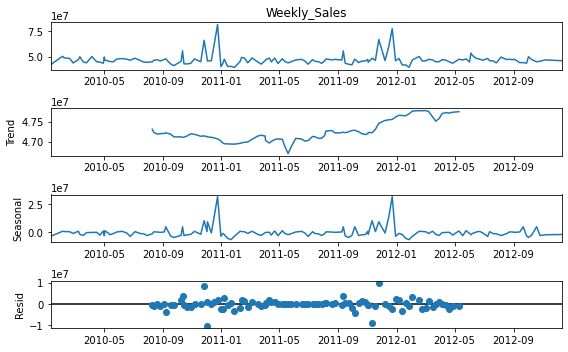

In [23]:
# Plot trend, seasonal, and residual components for the aggregate sales
# to reveal underlying patterns that are not apparent in the time series plot
decomposition_top = seasonal_decompose(aggregate_sales.set_index('Date')['Weekly_Sales'], model='additive', period=52)
plt.rcParams.update({'figure.figsize': (8,5)})
decomposition_top.plot()
plt.show()

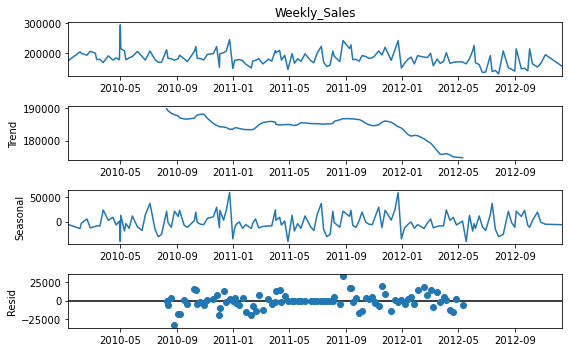

In [24]:
# Plot trend, seasonal, and residual components for the top_performer
# to reveal underlying patterns that are not apparent in the time series plot
decomposition_agg = seasonal_decompose(top_performer.set_index('Date')['Weekly_Sales'], model='additive', period=52)
plt.rcParams.update({'figure.figsize': (8,5)})
decomposition_agg.plot()
plt.show()

### Test for Stationarity 

#### Augmented Dickey-Fuller Test

In [27]:
# Create a function that performs the ADF test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')  
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [28]:
# Apply the function to the aggregate_sales['Weekly_Sales'] 
adf_test(aggregate_sales['Weekly_Sales'])

p-value: 0.000000
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


In [29]:
# Apply the function to the top_performer['Weekly_Sales'] 
adf_test(top_performer['Weekly_Sales'])

p-value: 0.001183
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578


#### Kwiatkowski-Phillips-Schmidt-Shin Test

In [30]:
# Create a function that performs the KPSS test
def kpss_test(timeseries):
    statistic, p_value, lags, critical_values = kpss(timeseries, 'c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'\t{key}: {value}')

In [31]:
# Apply the function to the aggregate_sales['Weekly_Sales'] 
kpss_test(aggregate_sales['Weekly_Sales'])

KPSS Statistic: 0.045319698887147895
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [32]:
# Apply the function to the top_performer['Weekly_Sales'] 
kpss_test(top_performer['Weekly_Sales'])

KPSS Statistic: 0.8702164672470161
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


#### Rolling Statistics

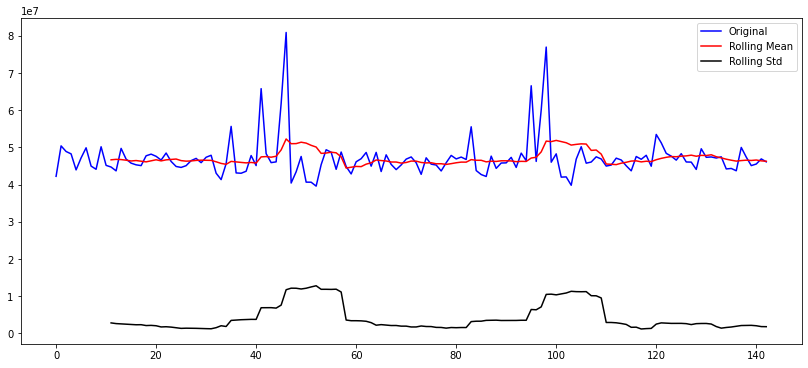

In [33]:
# Rolling statistics will be plotted
rolling_mean_a = aggregate_sales['Weekly_Sales'].rolling(window=12).mean()
rolling_std_a = aggregate_sales['Weekly_Sales'].rolling(window=12).std()

# Plot the figures
plt.figure(figsize=(14, 6))
plt.plot(aggregate_sales['Weekly_Sales'], color='blue', label='Original')
plt.plot(rolling_mean_a, color='red', label='Rolling Mean')
plt.plot(rolling_std_a, color='black', label='Rolling Std')
plt.legend()

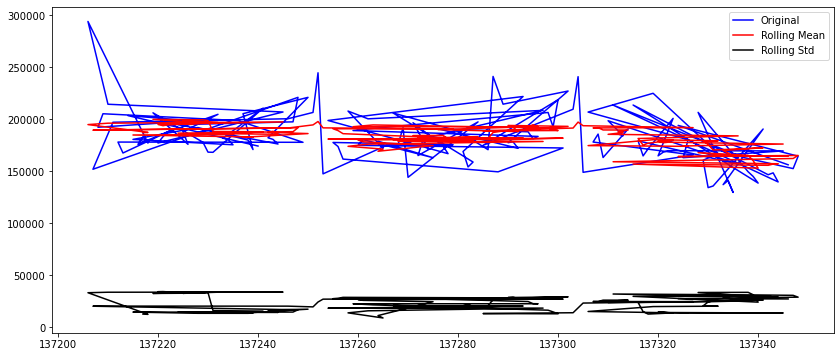

In [34]:
# Both tests and the figure above indicate Aggregate_sales is stationary but KPSS test suggests that top_performer needs further investigation
# Rolling statistics will be plotted
rolling_mean = top_performer['Weekly_Sales'].rolling(window=12).mean()
rolling_std = top_performer['Weekly_Sales'].rolling(window=12).std()

# Plot the figures
plt.figure(figsize=(14, 6))
plt.plot(top_performer['Weekly_Sales'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend()

### Determine Seasonality

In [43]:
df_sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


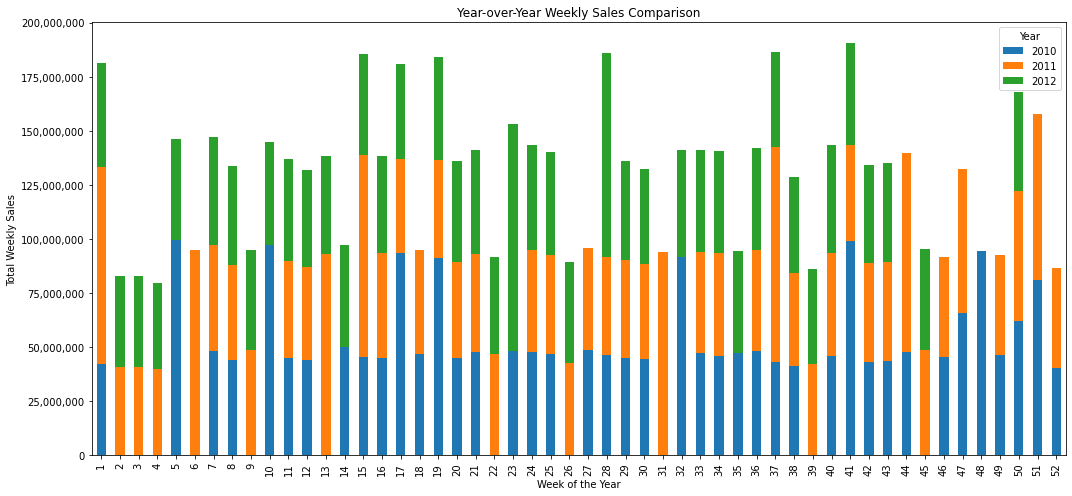

In [44]:
# Set the date column as the index
df_sales.set_index('Date', inplace=True)
# Extracting week and year from Date
df_sales['Year'] = df_sales.index.year
df_sales['Week'] = df_sales.index.isocalendar().week
df_sales['Month'] = df_sales.index.month

# Aggregating sales by Year and Week
weekly_sales_yoy = df_sales.groupby(['Year', 'Week'])['Weekly_Sales'].sum().unstack('Year')

# Plot configuration
fig, ax = plt.subplots(figsize=(15, 7))
weekly_sales_yoy.plot(kind='bar', stacked=True, ax=ax)

# Formatting the y-axis labels to be more readable
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title('Year-over-Year Weekly Sales Comparison')
plt.xlabel('Week of the Year')
plt.ylabel('Total Weekly Sales')
plt.legend(title='Year')

# Improve layout to accommodate the legend
plt.tight_layout()

plt.show()

#### ACF and PACF

<Figure size 504x288 with 0 Axes>

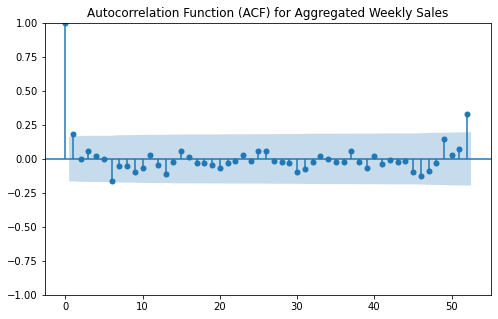

<Figure size 504x288 with 0 Axes>

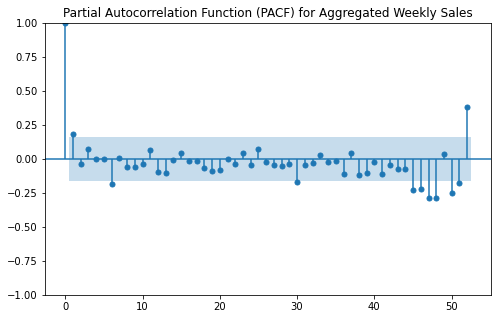

In [45]:
# Plotting the ACF for the 'aggregate_sales' dataframe
plt.figure(figsize=(7, 4))
plot_acf(aggregate_sales['Weekly_Sales'], lags=52, alpha=0.05)  
plt.title('Autocorrelation Function (ACF) for Aggregated Weekly Sales')
plt.show()

# Plotting the PACF for the 'aggregate_sales' dataframe
plt.figure(figsize=(7, 4))
plot_pacf(aggregate_sales['Weekly_Sales'], lags=52, alpha=0.05)  
plt.title('Partial Autocorrelation Function (PACF) for Aggregated Weekly Sales')
plt.show()

<Figure size 504x288 with 0 Axes>

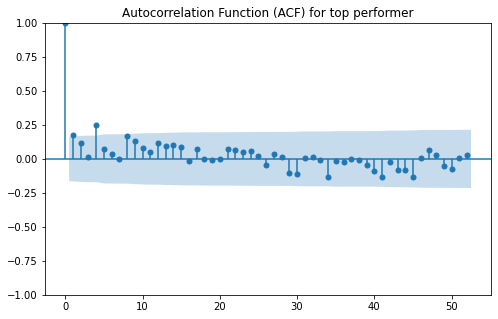

<Figure size 504x288 with 0 Axes>

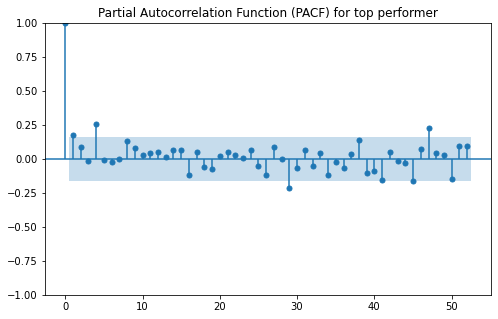

In [46]:
# Plotting the ACF for the 'top_performer' dataframe
plt.figure(figsize=(7, 4))
plot_acf(top_performer['Weekly_Sales'], lags=52, alpha=0.05)  
plt.title('Autocorrelation Function (ACF) for top performer')
plt.show()

# Plotting the PACF for the 'top_performer' dataframe
plt.figure(figsize=(7, 4))
plot_pacf(top_performer['Weekly_Sales'], lags=52, alpha=0.05)  
plt.title('Partial Autocorrelation Function (PACF) for top performer')
plt.show()

### ARIMA/SARIMA models for aggregate_sales

#### Train/Test

In [95]:
# Determine the size of the dataset
num = len(aggregate_sales)

# Split the data into training and testing sets (e.g., 80/20 split)
split_point = int(num * 0.8)
train, test = aggregate_sales['Weekly_Sales'][:split_point], aggregate_sales['Weekly_Sales'][split_point:]

# Check the size of each dataset
print(f'Training set size: {len(train)}, Test set size: {len(test)}')

# Ensure the index continues to be the date 
train.index = aggregate_sales.index[:split_point]
test.index = aggregate_sales.index[split_point:]

Training set size: 114, Test set size: 29


#### ARIMA model

In [70]:
# Fit the ARIMA model
model_a = ARIMA(train, order=(0, 0, 22)) 
fitted_model_agg = model_a.fit()

# Make predictions
predictions = fitted_model_agg.forecast(steps=len(test))

In [71]:
# Calculate metrics
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions)

# For MAPE it will be computed manually
mape = np.mean(np.abs((test - predictions) / test)) 

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

MSE: 8391001818377.718, RMSE: 2896722.5994868265, MAE: 2144719.5637928126, MAPE: 0.04540858551429864


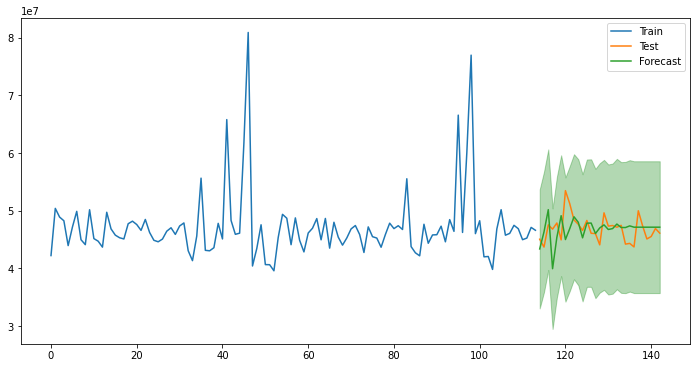

In [72]:
# Forecast
arima_forecast = fitted_model_agg.get_forecast(steps=len(test))
arima_forecast_mean = arima_forecast.predicted_mean

# Confidence intervals are also available
arima_forecast_ci = arima_forecast.conf_int()

# Plotting the forecast alongside the original series
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(arima_forecast_mean.index, arima_forecast_mean, label='Forecast')
plt.fill_between(arima_forecast_ci.index, arima_forecast_ci.iloc[:, 0], arima_forecast_ci.iloc[:, 1], color='g', alpha=0.3)
plt.legend()
plt.show()

#### Hypertuned Arima Model

In [73]:
# the auto_arima function is used to hypertune the arima/sarima models
arima_model = auto_arima(train,
                         start_p=0, start_q=0,  # Initial guess for AR and MA orders
                         max_p=25, max_q=25,    # Maximal AR and MA orders
                         d=None,                # Differencing order, if None it will be determined automatically
                         seasonal=False,        # No seasonality for ARIMA
                         trace=True,            # Print out the steps
                         error_action='ignore', # Don't want to know if an order does not work
                         suppress_warnings=True,# Suppress convergence warnings
                         stepwise=True)         # Stepwise search or not

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4355.892, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3943.993, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4280.147, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3882.924, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3884.868, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3884.768, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3884.968, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3882.751, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3884.799, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3886.794, Time=0.08 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.870 seconds


In [74]:
# Fit the ARIMA model with the new hypertuned parameters
model_a = ARIMA(train, order=(0, 0, 1))  
fitted_model_agg_h = model_a.fit()

# Make predictions
predictions = fitted_model_agg_h.forecast(steps=len(test))

In [75]:
# Calculate metrics
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions)

# For MAPE it will be computed manually
mape = np.mean(np.abs((test - predictions) / test)) 

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

MSE: 4978127853733.531, RMSE: 2231171.8566111242, MAE: 1680207.9413760805, MAPE: 0.03570665677919433


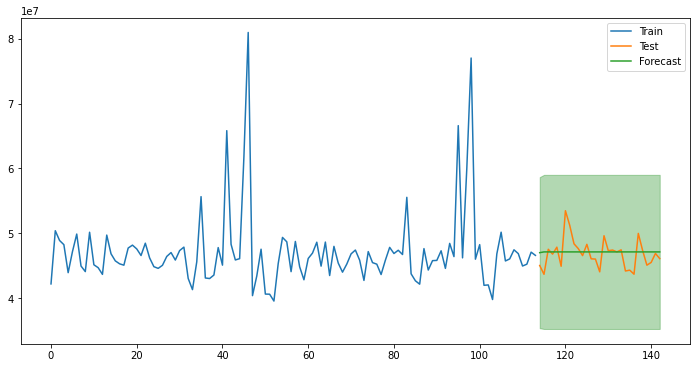

In [76]:
# Forecast
arima_forecast = fitted_model_agg_h.get_forecast(steps=len(test))
arima_forecast_mean = arima_forecast.predicted_mean

# Confidence intervals are also available
arima_forecast_ci = arima_forecast.conf_int()

# Plotting the forecast alongside the original series
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(arima_forecast_mean.index, arima_forecast_mean, label='Forecast')
plt.fill_between(arima_forecast_ci.index, arima_forecast_ci.iloc[:, 0], arima_forecast_ci.iloc[:, 1], color='g', alpha=0.3)
plt.legend()
plt.show()

#### SARIMA Model

In [77]:
# Use auto_arima for the sarima model
model = auto_arima(train, start_p=0, start_q=0,
                   max_p=25, max_q=25, m=12, # m is the seasonal period
                   start_P=0, seasonal=True,
                   d=None, D=1, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=3557.197, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3561.483, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3550.760, Time=0.18 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=3551.651, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3560.152, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3559.150, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3551.604, Time=0.36 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=3551.935, Time=0.29 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=3549.941, Time=0.20 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=3551.940, Time=0.65 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=3552.859, Time=0.92 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=3550.700, Time=0.19 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=3538.448, Time=0.37 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=3560.958, Time=0.08 sec
 ARIMA(1,0,1)(1,1,1

In [78]:
# Adjusted SARIMA model specification to avoid overlap
# already adjusted to the hypertuned parameters
model_s = SARIMAX(train,
                  order=(2, 0, 1),  # Adjusted non-seasonal MA order
                  seasonal_order=(0, 1, 1, 12))  # Adjusted seasonal parameters
fitted_model_s_agg = model_s.fit()

# Make predictions
predictions_s = fitted_model_s_agg.forecast(steps=len(test))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59961D+01    |proj g|=  1.22088D+00

At iterate    5    f=  1.55435D+01    |proj g|=  6.47515D-02

At iterate   10    f=  1.55265D+01    |proj g|=  1.02361D-02


 This problem is unconstrained.



At iterate   15    f=  1.54834D+01    |proj g|=  5.72219D-02

At iterate   20    f=  1.54599D+01    |proj g|=  3.54550D-03

At iterate   25    f=  1.54592D+01    |proj g|=  8.62677D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   1.767D-05   1.546D+01
  F =   15.459184143711921     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [79]:
# Calculate metrics
mse = mean_squared_error(test, predictions_s)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions_s)

# For MAPE it will be computed manually
mape = np.mean(np.abs((test - predictions_s) / test)) 

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

MSE: 8582060063961.256, RMSE: 2929515.329190352, MAE: 2146362.4755902276, MAPE: 0.04545181319219896


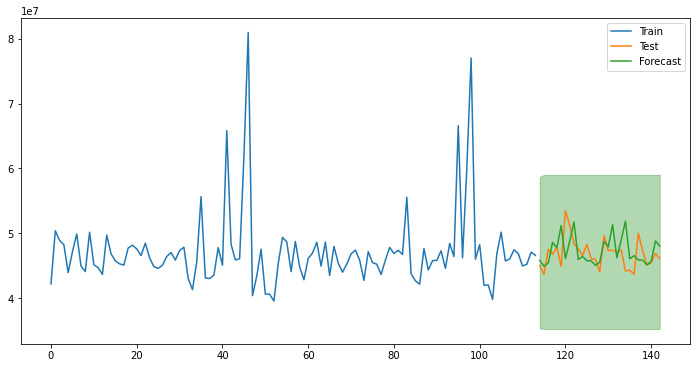

In [80]:
# Forecast
sarima_forecast = fitted_model_s_agg.get_forecast(steps=len(test))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Confidence intervals are also available
sarima_forecast_ci = sarima_forecast.conf_int()

# Plotting the forecast alongside the original series
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(sarima_forecast_mean.index, sarima_forecast_mean, label='Forecast')
plt.fill_between(arima_forecast_ci.index, arima_forecast_ci.iloc[:, 0], arima_forecast_ci.iloc[:, 1], color='g', alpha=0.3)
plt.legend()
plt.show()

### ARIMA/SARIMA models for top_performer

#### Train/Test Split

In [97]:
# Determine the size of the dataset
num = len(top_performer)

# Split the data into training and testing sets (e.g., 80/20 split)
split_point = int(num * 0.8)
train, test = top_performer['Weekly_Sales'][:split_point], top_performer['Weekly_Sales'][split_point:]

# Check the size of each dataset
print(f'Training set size: {len(train)}, Test set size: {len(test)}')

# Ensure the index continues to be the date if it was set earlier
train.index = aggregate_sales.index[:split_point]
test.index = aggregate_sales.index[split_point:]

Training set size: 114, Test set size: 29


In [101]:
train.head()

0    174219.51
1    203457.42
2    198349.17
3    192282.19
4    205250.96
Name: Weekly_Sales, dtype: float64

#### ARIMA Model

In [103]:
# Fit the ARIMA model
model_a = ARIMA(train, order=(8, 0, 22))  # Replace p, d, q with your chosen parameters
fitted_model_top = model_a.fit()

# Make predictions
predictions = fitted_model_top.forecast(steps=len(test))

In [104]:
# Calculate metrics
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions)

# For MAPE, SMAPE, and other metrics not directly available, you would need to compute them manually.
# Example MAPE calculation:
mape = np.mean(np.abs((test - predictions) / test)) 

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

MSE: 1336954400.568099, RMSE: 36564.387053088954, MAE: 32254.2367926004, MAPE: 0.2103006536609996


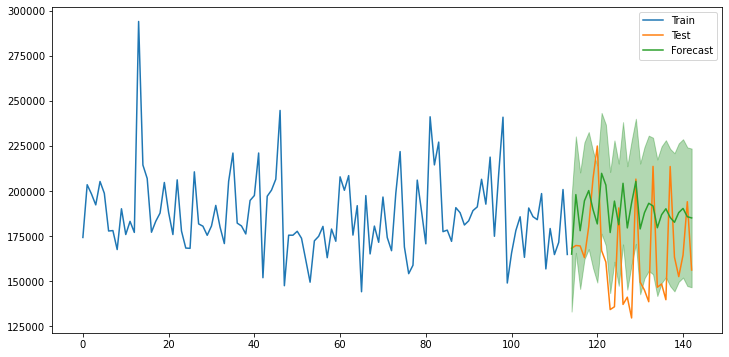

In [105]:
# Forecast
arima_forecast = fitted_model_top.get_forecast(steps=len(test))
arima_forecast_mean = arima_forecast.predicted_mean

# Confidence intervals are also available
arima_forecast_ci = arima_forecast.conf_int()

# Plotting the forecast alongside the original series
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(arima_forecast_mean.index, arima_forecast_mean, label='Forecast')
plt.fill_between(arima_forecast_ci.index, arima_forecast_ci.iloc[:, 0], arima_forecast_ci.iloc[:, 1], color='g', alpha=0.3)
plt.legend()
plt.show()

#### Hypertuned Arima Model

In [106]:
# the auto_arima function is used to hypertune the arima/sarima models
arima_model = auto_arima(train,
                         start_p=0, start_q=0,  # Initial guess for AR and MA orders
                         max_p=25, max_q=25,    # Maximal AR and MA orders
                         d=None,                # Differencing order, if None it will be determined automatically
                         seasonal=False,        # No seasonality for ARIMA
                         trace=True,            # Print out the steps
                         error_action='ignore', # Don't want to know if an order does not work
                         suppress_warnings=True,# Suppress convergence warnings
                         stepwise=True)         # Stepwise search or not

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3094.471, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2678.713, Time=0.68 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3021.845, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2623.595, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2625.298, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2623.278, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3003.837, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2624.878, Time=0.26 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2999.917, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2612.887, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2610.897, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2609.1

In [107]:
# Fit the ARIMA model
model_a = ARIMA(train, order=(0, 0, 0))  
fitted_model_top_h = model_a.fit()

# Make predictions
predictions = fitted_model_top_h.forecast(steps=len(test))

In [108]:
# Calculate metrics
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions)

# For MAPE it will be computed manually
mape = np.mean(np.abs((test - predictions) / test)) 

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

MSE: 1153831369.366307, RMSE: 33968.093401989856, MAE: 30732.912150635224, MAPE: 0.1998178426255307


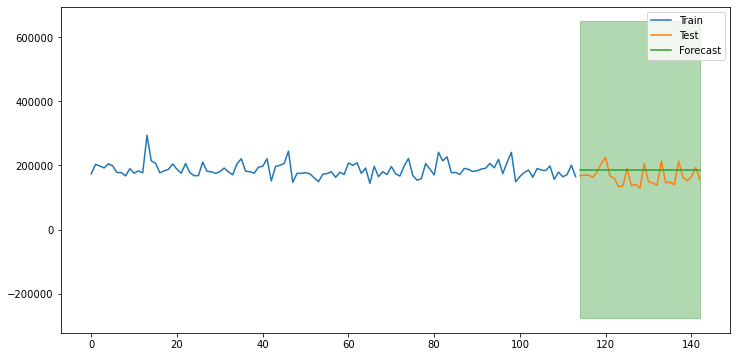

In [109]:
# Forecast
arima_forecast = fitted_model_top_h.get_forecast(steps=len(test))
arima_forecast_mean = arima_forecast.predicted_mean

# Confidence intervals are also available
arima_forecast_ci = arima_forecast.conf_int()

# Plotting the forecast alongside the original series
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(arima_forecast_mean.index, arima_forecast_mean, label='Forecast')
plt.fill_between(arima_forecast_ci.index, arima_forecast_ci.iloc[:, 0], arima_forecast_ci.iloc[:, 1], color='g', alpha=0.3)
plt.legend()
plt.show()

#### SARIMA model

In [110]:
# Assuming 'train' is your training dataset
model = auto_arima(train, start_p=0, start_q=0,
                   max_p=25, max_q=25, m=12, # m is the seasonal period
                   start_P=0, seasonal=True,
                   d=None, D=1, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=2408.920, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2407.881, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2407.828, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2408.924, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2406.632, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=2409.014, Time=0.11 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=2410.350, Time=0.32 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2408.320, Time=0.06 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=2408.825, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=2409.539, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12]          
Total fit time: 1.147 seconds


In [117]:
# Adjusted SARIMA model specification to avoid overlap
model_s = SARIMAX(train,
                  order=(0, 0, 0),  # Adjusted non-seasonal MA order
                  seasonal_order=(0, 1, 0, 12))  # Adjusted seasonal parameters
fitted_model_s_top = model_s.fit()

# Make predictions
predictions_s = fitted_model_s_top.forecast(steps=len(test))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05466D+01    |proj g|=  3.50600D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.506D-06   1.055D+01
  F =   10.546629391442226     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [118]:
# Calculate metrics
mse = mean_squared_error(test, predictions_s)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions_s)

# For MAPE, SMAPE, and other metrics not directly available, you would need to compute them manually.
# Example MAPE calculation:
mape = np.mean(np.abs((test - predictions_s) / test)) 

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}")

MSE: 1178405918.3429832, RMSE: 34327.91747751359, MAE: 28695.001724137925, MAPE: 0.1816660075747101


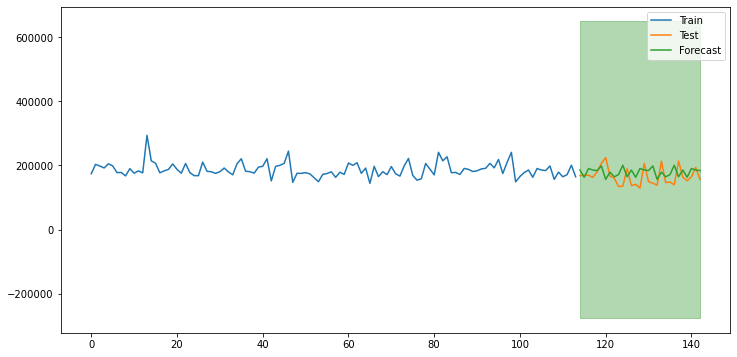

In [119]:
# Forecast
sarima_forecast = fitted_model_s_top.get_forecast(steps=len(test))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Confidence intervals are also available
sarima_forecast_ci = sarima_forecast.conf_int()

# Plotting the forecast alongside the original series
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(sarima_forecast_mean.index, sarima_forecast_mean, label='Forecast')
plt.fill_between(arima_forecast_ci.index, arima_forecast_ci.iloc[:, 0], arima_forecast_ci.iloc[:, 1], color='g', alpha=0.3)
plt.legend()
plt.show()

### Prophet Model for Aggregate Sales

In [120]:
# Set the hyperparameters for the model:
m = Prophet(interval_width=.95, 
            daily_seasonality=False, 
            weekly_seasonality=True).fit(aggregate_sales_prophet)

# Forecasting 77 weeks (1.5 years) into the future.
future = m.make_future_dataframe(periods=77, freq='W')
forecast = m.predict(future)

# Plot the forecast
plot_plotly(m, forecast)

20:49:39 - cmdstanpy - INFO - Chain [1] start processing
20:49:39 - cmdstanpy - INFO - Chain [1] done processing


In [121]:
plot_components_plotly(m, forecast)

In [122]:
# Define a cross validation function to use in finding the performance metrics
def CrossValidateData(m):
        c_v = cross_validation(m, 
                               initial='120W',   # Initially, the model will be trained in 120 weeks.
                               period='2W',      # After each model tested, we'll add 2 more weeks.
                               horizon ='2W',    # The forecasting will happen in a range of 2 weeks.
                               parallel="processes",   # To acellerate the cross-validation.
                              )
        return c_v
# Define a function which displays the performance metrics using cross validation
def PerfomanceMetrics(m):
    return performance_metrics(CrossValidateData(m), 
                               rolling_window=1, # Generate metrics for the whole (100%) seen data.
                              )

In [123]:
PerfomanceMetrics(m).mean()

20:50:14 - cmdstanpy - INFO - Chain [1] start processing
20:50:14 - cmdstanpy - INFO - Chain [1] start processing
20:50:14 - cmdstanpy - INFO - Chain [1] start processing
20:50:14 - cmdstanpy - INFO - Chain [1] start processing
20:50:14 - cmdstanpy - INFO - Chain [1] done processing
20:50:14 - cmdstanpy - INFO - Chain [1] done processing
20:50:14 - cmdstanpy - INFO - Chain [1] done processing
20:50:14 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:15 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:15 - cmdstanpy - INFO - Chain [1]

horizon          14 days 00:00:00
mse         14373347623026.966797
rmse               3791219.806741
mae                2430278.510532
mape                     0.051443
mdape                    0.027952
smape                    0.049398
coverage                 0.962963
dtype: object

In [124]:
# Create a dataframe with all the known holidays in the united states
# to then use it in the following model
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2011-02-06', '2012-02-05', '2013-02-03']),
  'lower_window': -2,
  'upper_window': 2,
})
easter = pd.DataFrame({
  'holiday': 'easter',
  'ds': pd.to_datetime(['2010-04-05', '2011-04-25', '2012-04-09', '2013-04-01']),
  'lower_window': -2,
  'upper_window': 1,
})
mothers_day = pd.DataFrame({
    'holiday': "mother's day",
    'ds': pd.to_datetime(['2010-05-09', '2011-05-08', '2012-05-13', '2013-02-12']),
    'lower_window': -3,
    'upper_window': 0,
})
fathers_day = pd.DataFrame({
    'holiday': "father's day",
    'ds': pd.to_datetime(['2010-06-19', '2011-06-19', '2012-06-17', '2013-06-16']),
    'lower_window': -3,
    'upper_window': 0,
})
halloween = pd.DataFrame({
    'holiday': "father's day",
    'ds': pd.to_datetime(['2010-10-31', '2011-10-31', '2012-10-31', '2013-10-31']),
    'lower_window': -3,
    'upper_window': 2,
})
black_friday = pd.DataFrame({
    'holiday': "black friday",
    'ds': pd.to_datetime(['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']),
    'lower_window': 0,
    'upper_window': 0,
})
cyber_monday = pd.DataFrame({
    'holiday': "cyber monday",
    'ds': pd.to_datetime(['2010-11-29', '2011-11-28', '2012-12-26', '2013-12-02']),
    'lower_window': 0,
    'upper_window': 0,
})

holidays = pd.concat((superbowls, 
                      easter,
                      mothers_day, 
                      fathers_day, 
                      halloween, 
                      black_friday, 
                      cyber_monday))

In [125]:
m = Prophet(holidays=holidays,
            interval_width=.95, 
            daily_seasonality=False)
m.add_country_holidays(country_name='US')
m.fit(aggregate_sales_prophet)
future = m.make_future_dataframe(periods=77, freq='W')
forecast = m.predict(future)
plot_plotly(m, forecast)

20:51:03 - cmdstanpy - INFO - Chain [1] start processing
20:51:03 - cmdstanpy - INFO - Chain [1] done processing


In [126]:
plot_components_plotly(m, forecast)

In [127]:
# Get the performance metrics for the model with holidays
PerfomanceMetrics(m).mean()

20:51:40 - cmdstanpy - INFO - Chain [1] start processing
20:51:40 - cmdstanpy - INFO - Chain [1] start processing
20:51:40 - cmdstanpy - INFO - Chain [1] start processing
20:51:40 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing
20:51:41 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing
20:51:42 - cmdstanpy - INFO - Chain [1] start processing
20:51:42 - cmdstanpy - INFO - Chain [1]

horizon          14 days 00:00:00
mse         11121082127507.615234
rmse               3334828.650397
mae                2248925.192382
mape                     0.047601
mdape                    0.029593
smape                    0.045883
coverage                 0.851852
dtype: object

### Prophet Model for Top performer

In [128]:
# Set the hyperparameters for the model
m = Prophet(interval_width=.95, 
            daily_seasonality=False, 
            weekly_seasonality=True).fit(top_performer_prophet)

# Forecasting 77 weeks (1.5 years) into the future.
future = m.make_future_dataframe(periods=77, freq='W')
forecast = m.predict(future)

# Plotting.
plot_plotly(m, forecast)

20:51:50 - cmdstanpy - INFO - Chain [1] start processing
20:51:50 - cmdstanpy - INFO - Chain [1] done processing


In [129]:
plot_components_plotly(m, forecast)

In [130]:
PerfomanceMetrics(m).mean()

20:52:36 - cmdstanpy - INFO - Chain [1] start processing
20:52:36 - cmdstanpy - INFO - Chain [1] start processing
20:52:36 - cmdstanpy - INFO - Chain [1] start processing
20:52:36 - cmdstanpy - INFO - Chain [1] start processing
20:52:36 - cmdstanpy - INFO - Chain [1] done processing
20:52:36 - cmdstanpy - INFO - Chain [1] done processing
20:52:36 - cmdstanpy - INFO - Chain [1] done processing
20:52:36 - cmdstanpy - INFO - Chain [1] done processing
20:52:36 - cmdstanpy - INFO - Chain [1] start processing
20:52:36 - cmdstanpy - INFO - Chain [1] start processing
20:52:36 - cmdstanpy - INFO - Chain [1] start processing
20:52:36 - cmdstanpy - INFO - Chain [1] start processing
20:52:36 - cmdstanpy - INFO - Chain [1] done processing
20:52:36 - cmdstanpy - INFO - Chain [1] done processing
20:52:36 - cmdstanpy - INFO - Chain [1] done processing
20:52:36 - cmdstanpy - INFO - Chain [1] done processing
20:52:37 - cmdstanpy - INFO - Chain [1] start processing
20:52:37 - cmdstanpy - INFO - Chain [1]

horizon     14 days 00:00:00
mse         845689396.597538
rmse            29080.739272
mae             25074.823258
mape                0.161497
mdape               0.117552
smape               0.147429
coverage            0.740741
dtype: object

In [131]:
m = Prophet(holidays=holidays,
            interval_width=.95, 
            daily_seasonality=False)
m.add_country_holidays(country_name='US')
m.fit(top_performer_prophet)
future = m.make_future_dataframe(periods=77, freq='W')
forecast = m.predict(future)
plot_plotly(m, forecast)

20:52:38 - cmdstanpy - INFO - Chain [1] start processing
20:52:38 - cmdstanpy - INFO - Chain [1] done processing


In [132]:
plot_components_plotly(m, forecast)

In [133]:
PerfomanceMetrics(m).mean()

20:53:13 - cmdstanpy - INFO - Chain [1] start processing
20:53:13 - cmdstanpy - INFO - Chain [1] start processing
20:53:13 - cmdstanpy - INFO - Chain [1] start processing
20:53:13 - cmdstanpy - INFO - Chain [1] start processing
20:53:13 - cmdstanpy - INFO - Chain [1] done processing
20:53:13 - cmdstanpy - INFO - Chain [1] done processing
20:53:13 - cmdstanpy - INFO - Chain [1] done processing
20:53:13 - cmdstanpy - INFO - Chain [1] done processing
20:53:14 - cmdstanpy - INFO - Chain [1] start processing
20:53:14 - cmdstanpy - INFO - Chain [1] start processing
20:53:15 - cmdstanpy - INFO - Chain [1] start processing
20:53:15 - cmdstanpy - INFO - Chain [1] start processing
20:53:15 - cmdstanpy - INFO - Chain [1] done processing
20:53:15 - cmdstanpy - INFO - Chain [1] done processing
20:53:15 - cmdstanpy - INFO - Chain [1] done processing
20:53:15 - cmdstanpy - INFO - Chain [1] done processing
20:53:15 - cmdstanpy - INFO - Chain [1] start processing
20:53:15 - cmdstanpy - INFO - Chain [1]

horizon     14 days 00:00:00
mse          822952562.41482
rmse            28687.149779
mae             24811.572972
mape                  0.1594
mdape               0.121093
smape               0.146142
coverage             0.62963
dtype: object

In [134]:
# Picking only useful regressors for Store 14.
store_14 = df_features[df_features.Store == 14].drop(['Store', 'CPI', 'Unemployment', 'IsHoliday'], axis=1)

# Converting it to datetime type.
store_14['Date'] = pd.to_datetime(store_14['Date'])

# Merging a new dataframe with the regressors.
df = store_14.merge(top_performer[['Date', 'Weekly_Sales']], on='Date')

# Renaming columns.
df.rename({'Date': 'ds', 'Weekly_Sales': 'y'}, axis=1, inplace=True)
store_14.rename({'Date': 'ds'}, axis=1, inplace=True)

# Defining regressors names iterable.
regressors = df.drop(['ds', 'y'], axis=1).columns

In [135]:
m = Prophet(interval_width=.95, 
            daily_seasonality=False)

# Adding the regressors.
for regressor in regressors:
    m.add_regressor(regressor)

# Training.
m.fit(df)

# The forecast must have the same regressors. 
# In this case we're going to forecast until the end of February of the next year.
future = store_14[store_14.ds < '2013-12-29']
forecast = m.predict(future)
plot_plotly(m, forecast)

20:53:17 - cmdstanpy - INFO - Chain [1] start processing
20:53:17 - cmdstanpy - INFO - Chain [1] done processing


In [136]:
plot_components_plotly(m, forecast)

In [137]:
PerfomanceMetrics(m).mean()

20:53:35 - cmdstanpy - INFO - Chain [1] start processing
20:53:35 - cmdstanpy - INFO - Chain [1] start processing
20:53:35 - cmdstanpy - INFO - Chain [1] start processing
20:53:35 - cmdstanpy - INFO - Chain [1] start processing
20:53:35 - cmdstanpy - INFO - Chain [1] done processing
20:53:35 - cmdstanpy - INFO - Chain [1] done processing
20:53:35 - cmdstanpy - INFO - Chain [1] done processing
20:53:35 - cmdstanpy - INFO - Chain [1] done processing
20:53:36 - cmdstanpy - INFO - Chain [1] start processing
20:53:36 - cmdstanpy - INFO - Chain [1] start processing
20:53:36 - cmdstanpy - INFO - Chain [1] start processing
20:53:36 - cmdstanpy - INFO - Chain [1] done processing
20:53:36 - cmdstanpy - INFO - Chain [1] start processing
20:53:36 - cmdstanpy - INFO - Chain [1] done processing
20:53:36 - cmdstanpy - INFO - Chain [1] done processing
20:53:36 - cmdstanpy - INFO - Chain [1] done processing
20:53:36 - cmdstanpy - INFO - Chain [1] start processing
20:53:36 - cmdstanpy - INFO - Chain [1]

horizon     14 days 00:00:00
mse         658167289.322068
rmse            25654.771278
mae              22162.80702
mape                0.144138
mdape               0.134464
smape               0.132187
coverage            0.740741
dtype: object

### ARIMA/SARIMA Model Diagnostics

In [138]:
def model_diagnostics(model):
    fig = model.plot_diagnostics(figsize=(15, 12))
    return fig

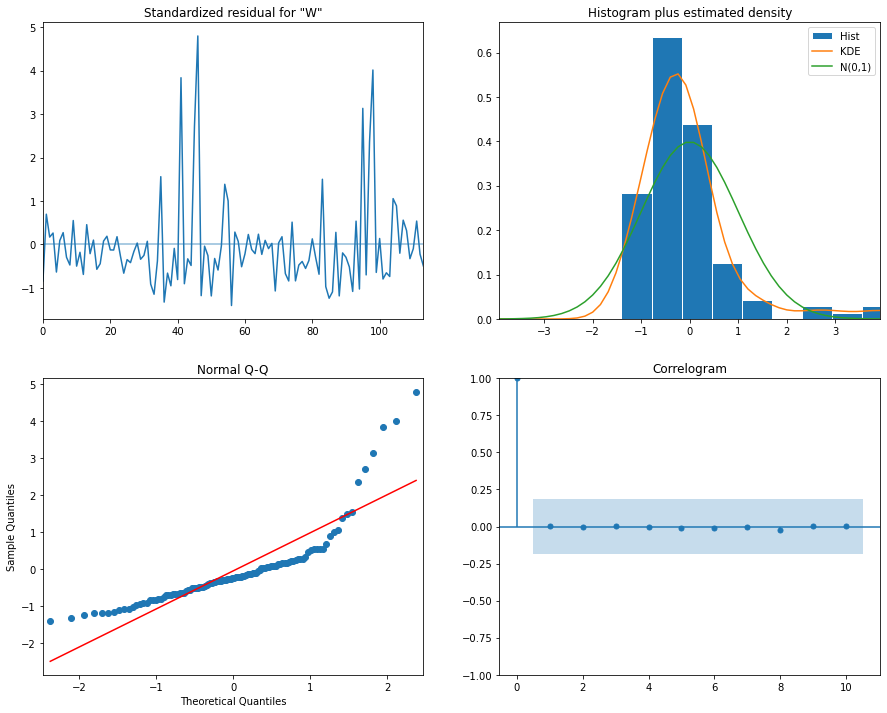

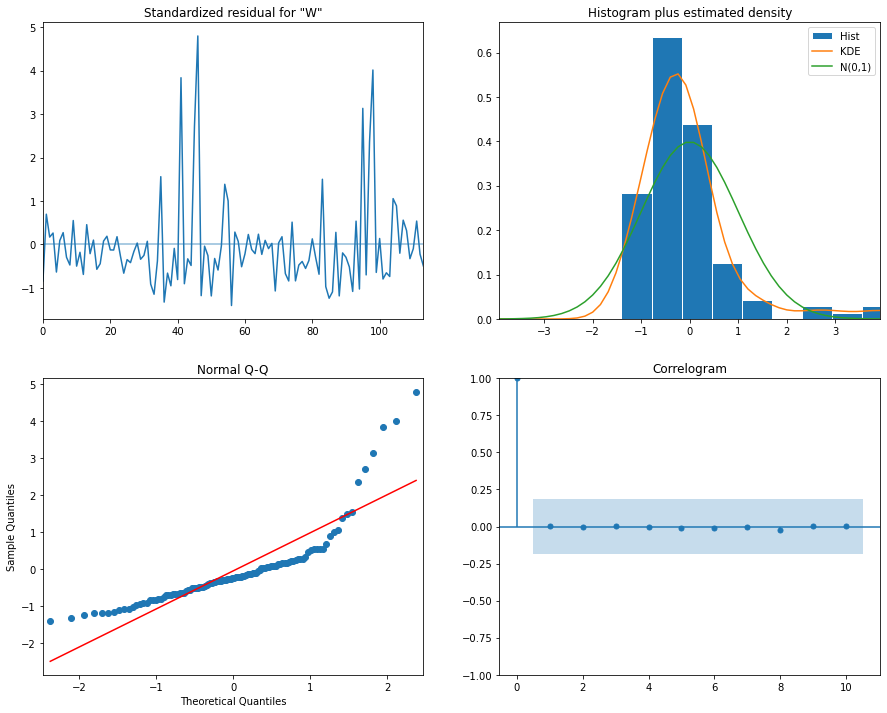

In [139]:
#Check the model diagnostics for the aggregate sales ARIMA model
model_diagnostics(fitted_model_agg)

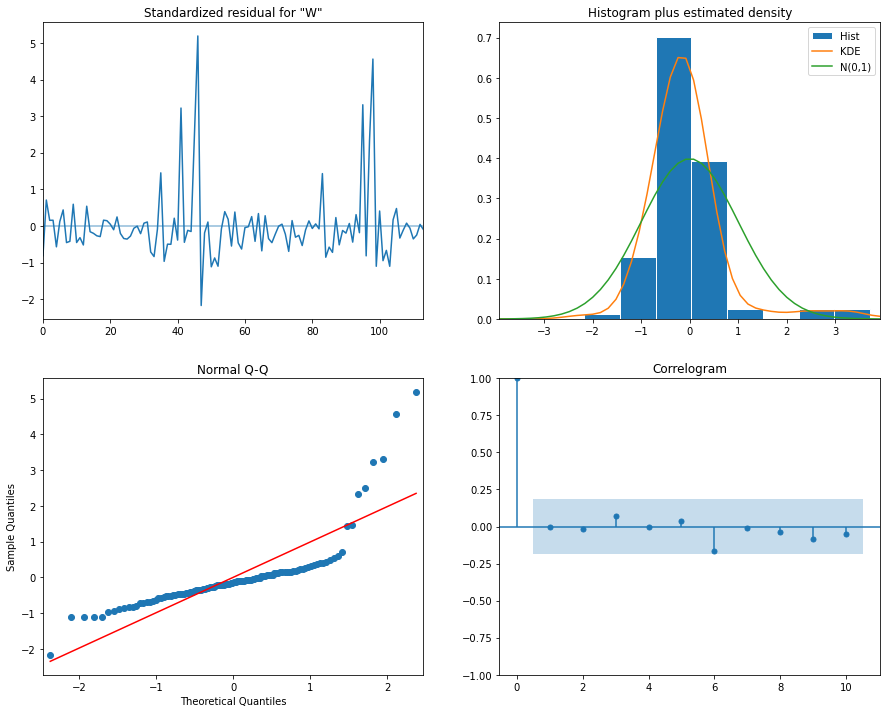

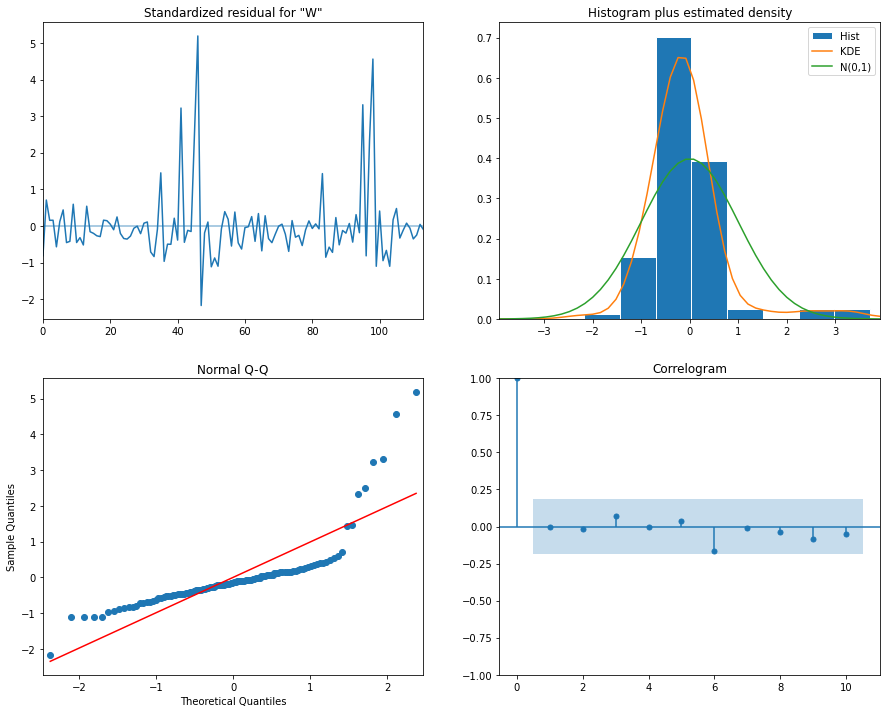

In [140]:
#Check the model diagnostics for the hypertuned aggregate sales ARIMA model
model_diagnostics(fitted_model_agg_h)

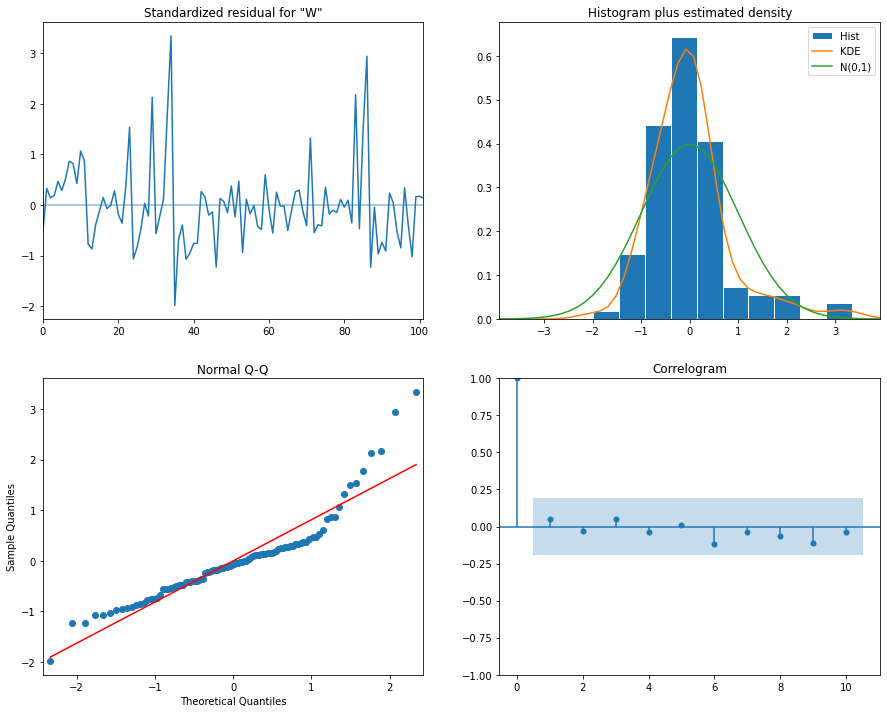

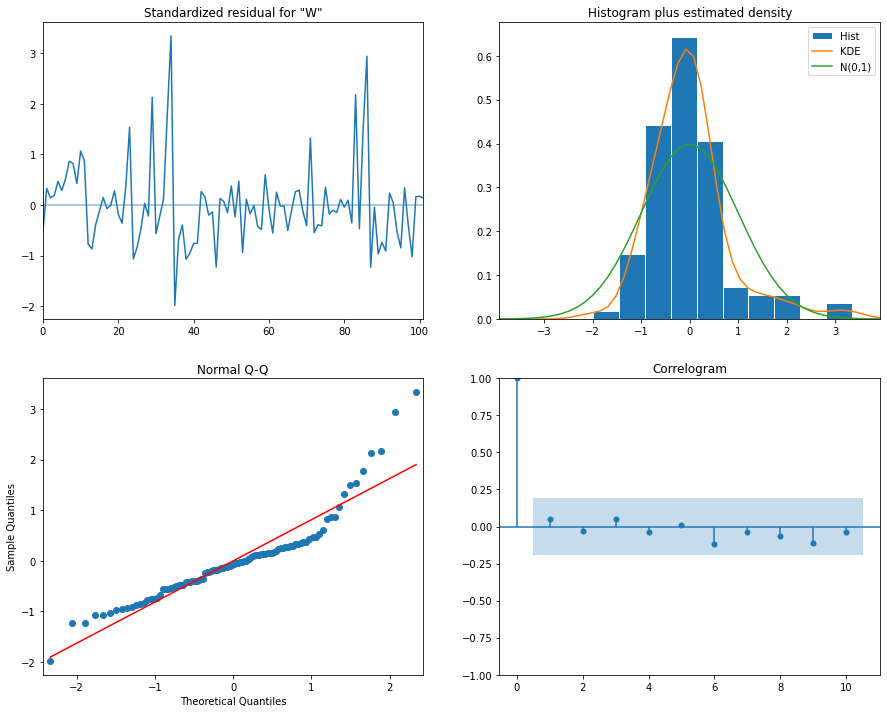

In [141]:
#Check the model diagnostics for the aggregate sales SARIMA model
model_diagnostics(fitted_model_s_agg)

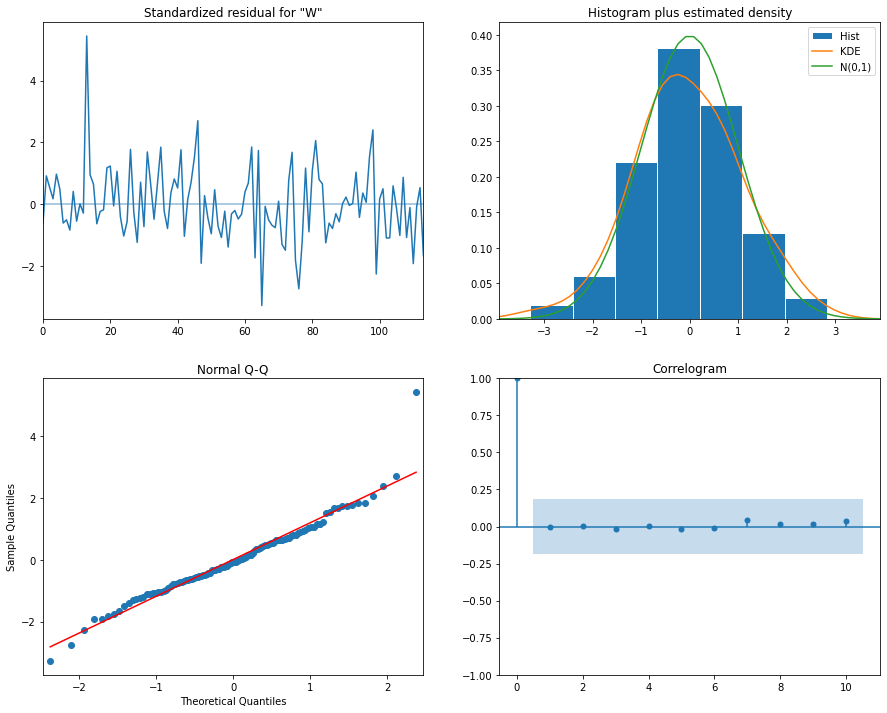

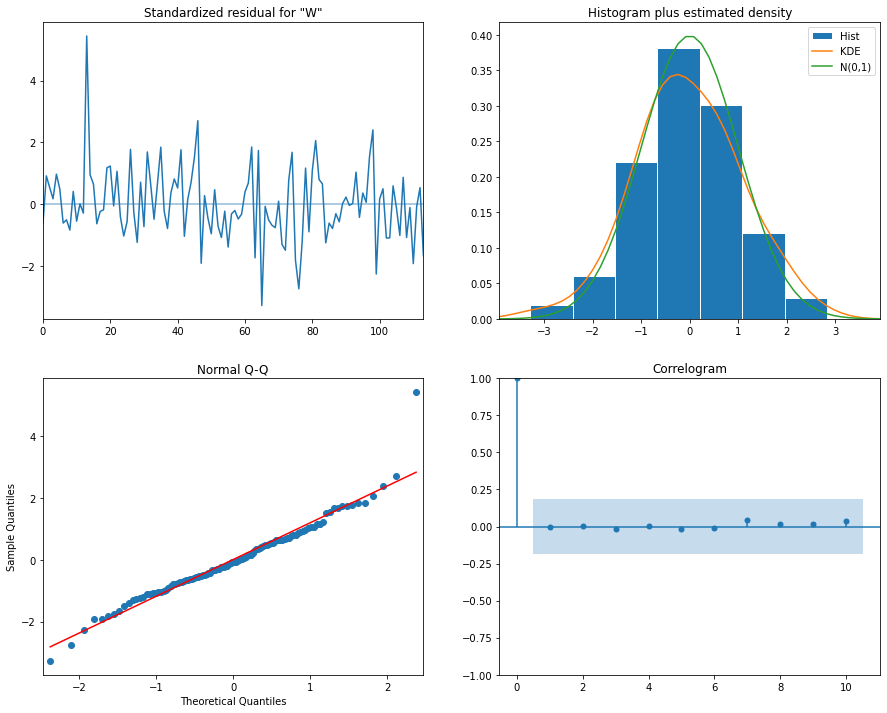

In [142]:
#Check the model diagnostics for the top performer ARIMA model
model_diagnostics(fitted_model_top)

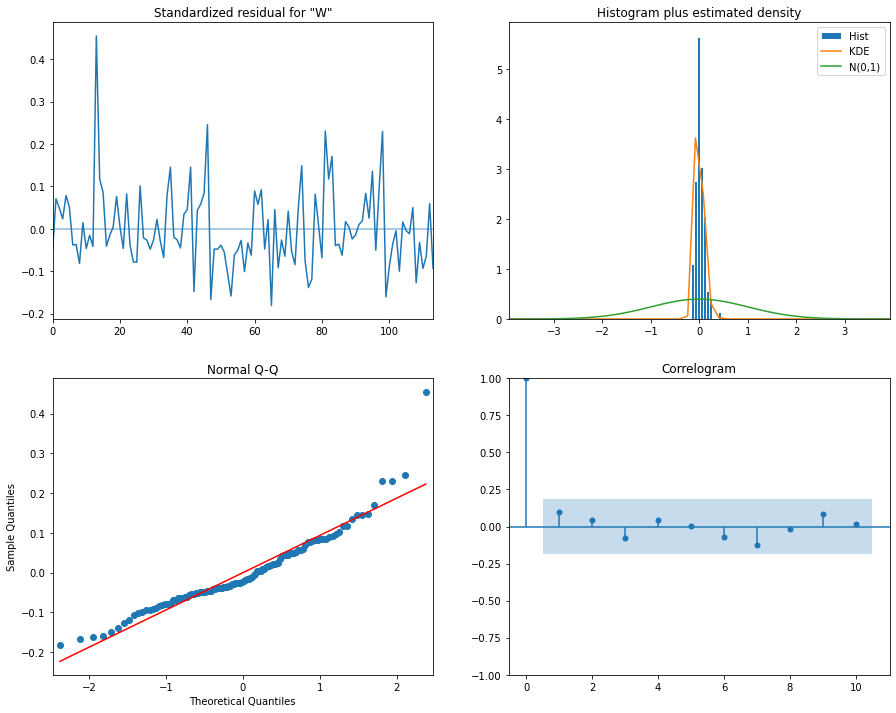

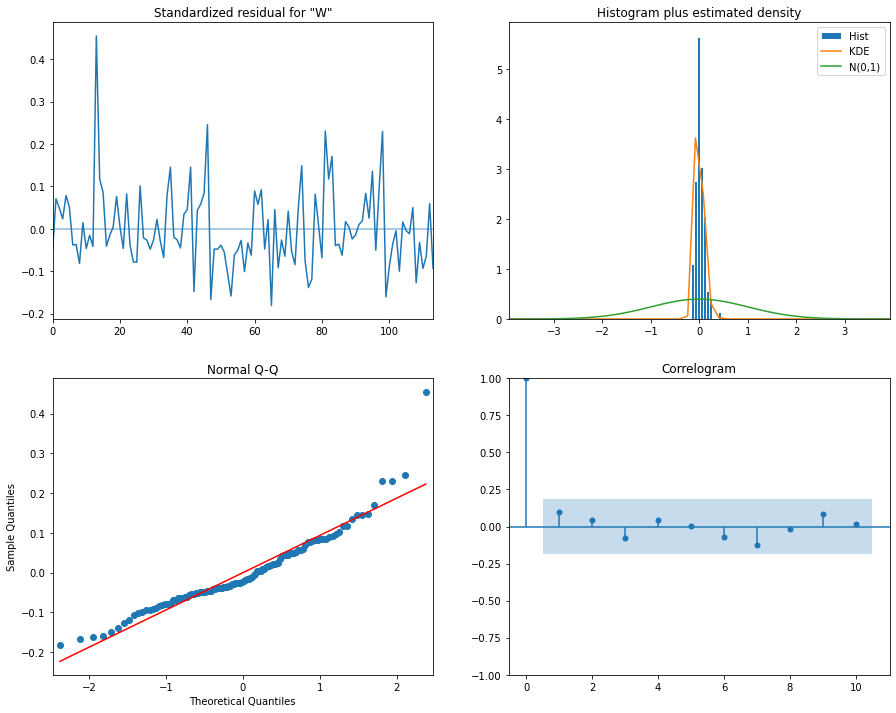

In [143]:
#Check the model diagnostics for the hypertuned aggregate sales ARIMA model
model_diagnostics(fitted_model_top_h)

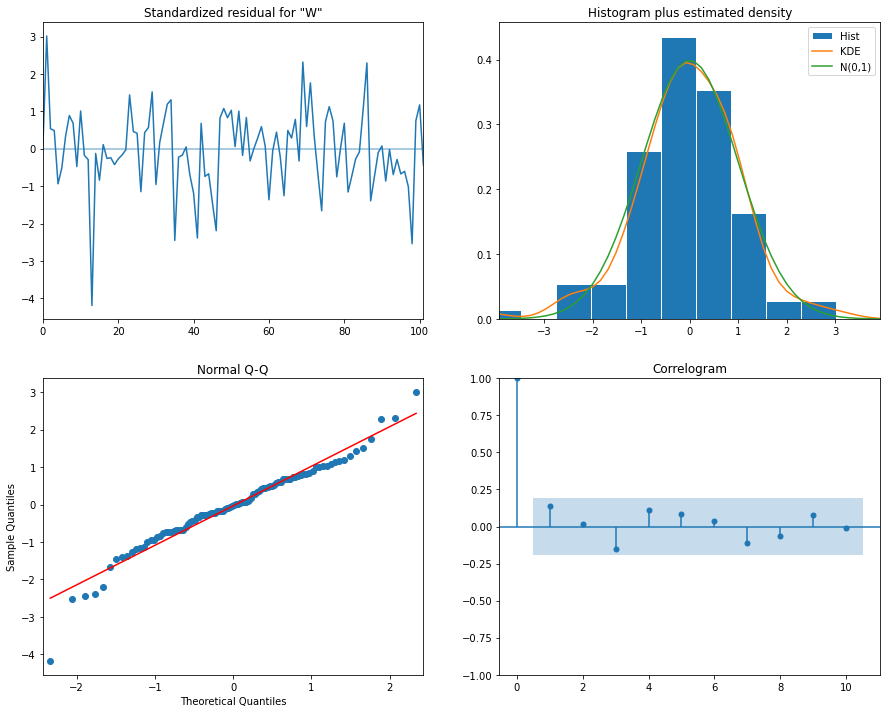

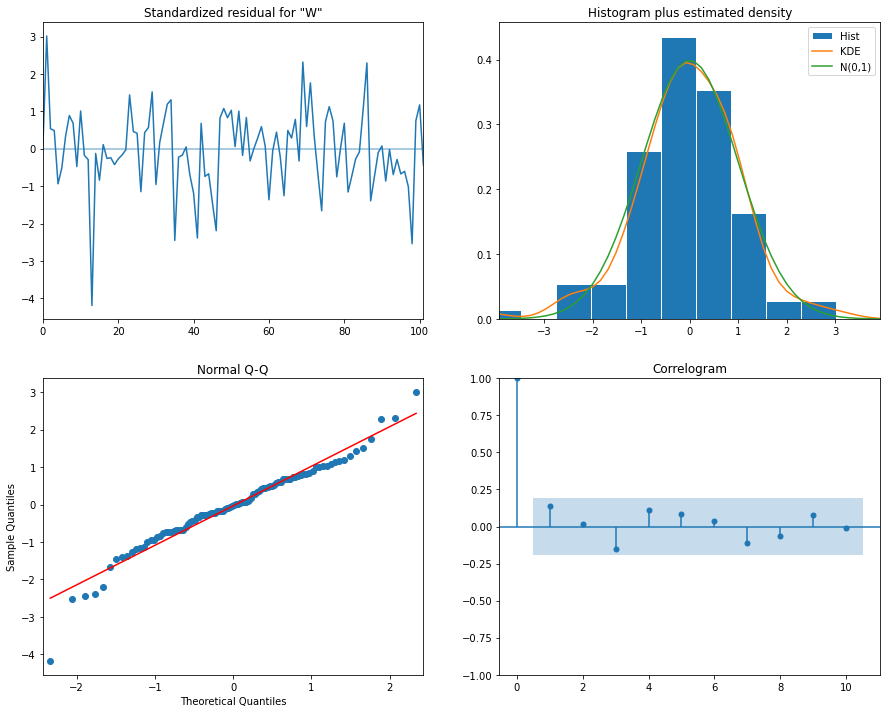

In [144]:
#Check the model diagnostics for the top performer SARIMA model
model_diagnostics(fitted_model_s_top)